In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt 
from scipy.spatial import Delaunay 
import skimage as sk
import scipy as sci
import cv2
import os 
from scipy.interpolate import interp2d

In [3]:
def read_pts(filename):
    return np.loadtxt(filename, comments=("version:", "n_points:", "{", "}"))

In [4]:
result = read_pts("../meanFace/points/1b.pts")

In [5]:
img = plt.imread("../meanFace/imagesSpatialNorm/1b.jpg")

<Figure size 640x480 with 0 Axes>

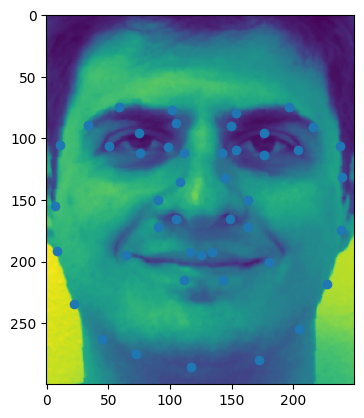

In [6]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.imshow(img)

plt.plot(result[:,0], result[:,1], 'o')
ax.set_aspect('equal', adjustable='box')

In [7]:
avgImg = np.zeros_like(plt.imread("../meanFace/imagesSpatialNorm/2a.jpg")).astype(np.float64)
for i in range(1, 201):
    avgImg += plt.imread(f"../meanFace/imagesSpatialNorm/{i}a.jpg").astype(np.float64) * (1/200)
avgImg = avgImg/np.max(avgImg)

(300, 250)

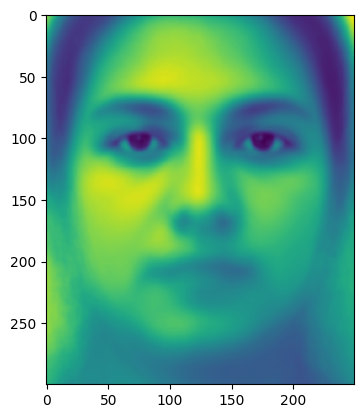

In [8]:
plt.imshow(avgImg)
plt.imsave("../meanFace/output/happyAverageFaceUpscaled.png", avgImg, cmap="grey")
avgImg.shape

In [9]:
# avgPoints = np.zeros_like(read_pts("../meanFace/points/2b.pts")).astype(np.float64)
avgPoints = np.array([read_pts(f"../meanFace/points/{i}a.pts") for i in range(1, 201)])
avgPoints.shape

(200, 46, 2)

In [10]:
avgPoints = np.array([read_pts(f"../meanFace/points/{i}a.pts") for i in range(1, 201)])
avgPoints = np.floor(np.average(avgPoints, axis=(0)))
avgPoints.shape

(46, 2)

<Figure size 640x480 with 0 Axes>

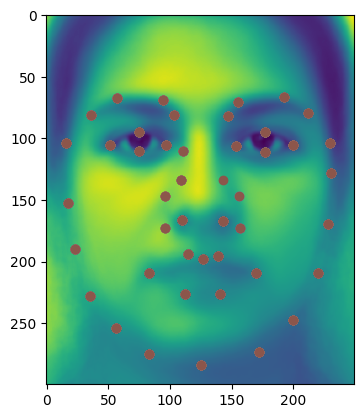

In [11]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.imshow(avgImg)

for i in range(0, avgPoints.shape[0]):
    plt.plot(avgPoints[:i,0], avgPoints[:i,1], 'o')
    ax.set_aspect('equal', adjustable='box')
    # plt.savefig(f"../meanFace/pointOrder/{i}.jpg")

In [27]:
#Triangle Vert is a 3x2 array
def imgToTriangle(triangleVert, img):
    triangleVert = np.array(triangleVert)
    centroid = np.array([np.average(triangleVert[:, 0]), np.average(triangleVert[:, 1])])
    # for idx in range(0, triangleVert.shape[0]):
    #     direction = triangleVert[idx] - centroid
    #     direction = direction/np.linalg.norm(direction)
    #     expandedVertex = triangleVert[idx] + direction * 1
    #     triangleVert[idx] = expandedVertex
    mask = sk.draw.polygon2mask(img.shape[0:3], triangleVert)
    # print(mask.shape)
    return img * mask
   #return np.stack(img[:,:,0] * mask, img[:,:,1] * mask, img[:,:,2] * mask, axis=2)

#Inverse transform from t1 to t2
def affineTrans(triIndex, t1Points, t1Simplicies, t2Points):
    t1 = [t1Points[i] for i in t1Simplicies[triIndex]]
    t2 = [t2Points[i] for i in t1Simplicies[triIndex]]
    # print(t1)
    # print(t2)
    t1Vec = np.array([t1[0] - t1[1],  t1[0] - t1[2]]).astype(np.float64).T
    t2Vec = np.array([t2[0] - t2[1],  t2[0] - t2[2]]).astype(np.float64).T
    # print(t1Vec)
    # print(t2Vec)
    t1VecToRight = np.eye(3)
    t1VecToRight[0:2, 0:2] = t1Vec
    t1VecToRight[0:2, 2] = t1[0]
    t1VecToRight = np.linalg.inv(t1VecToRight)

    rightToT2 = np.eye(3)
    rightToT2[0:2, 0:2] = t2Vec
    rightToT2[0:2, 2] = t2[0]

    return rightToT2 @ t1VecToRight
    
def warpImg(im1Points, im1Tri, im2Points, img):
    warpedIm2 = np.zeros_like(img).astype(np.float64)
    for i in range(0, len(im1Tri.simplices)):
        maskedIm2 = imgToTriangle([[im2Points[i][1],im2Points[i][0]] for i in im1Tri.simplices[i]], img)
        inverseMap = affineTrans(i, im1Points, im1Tri.simplices, im2Points)
        # print(type(inverseMap[0,0]))
        triangle = sk.transform.warp(maskedIm2, inverseMap)
        warpedIm2 += triangle
        # warpedIm2 = np.clip(warpedIm2, 0, 1)
        # warpedIm2 = np.where(triangle != 0, triangle, warpedIm2)
    return warpedIm2

def warpWithRatio(im1, im1Points, im2, im2Points, crossRatio, morphRatio):
    # averageImg = np.average([im2Points[0], im2Points[0]], weights=[morphRatio, 1-morphRatio], axis=0)
    averagePoints = [np.average(a, weights=[morphRatio, 1-morphRatio], axis=0) for a in zip(im1Points, im2Points)]
    averagePoints = np.array(averagePoints) 
    triAverage = Delaunay(averagePoints)
    img1Warp = warpImg(averagePoints, triAverage, im1Points, im1)
    img2Warp = warpImg(averagePoints, triAverage, im2Points, im2)
    interpolatedImg = img1Warp * crossRatio + img2Warp * (1-crossRatio)
    
    return interpolatedImg


In [38]:
im2 = plt.imread(f"../meanFace/upscaledImgs/21a.jpg").astype(np.float64)
im2Points = read_pts("../meanFace/points/21a.pts")*4
avgPoints = np.array([read_pts(f"../meanFace/points/{i}b.pts")*4 for i in range(1, 201)])
avgPoints = np.floor(np.average(avgPoints, axis=(0)))
avgPoints = list(avgPoints)
im2Points = list(im2Points)
avgPoints.extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
avgPoints.extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])
im2Points.extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
im2Points.extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])

avgPoints = np.array(avgPoints)
im2Points = np.array(im2Points)
triim2 = Delaunay(im2Points)
print(type(im2[0,0]))
print(type(avgPoints[0,0]))
print(type(im2[0,0]))
print(np.max(im2))
print(np.min(im2))

<class 'numpy.ndarray'>
<class 'numpy.float64'>
<class 'numpy.ndarray'>
148.0
2.0


In [39]:
warpedImg = warpImg(avgPoints, triim2, im2Points, im2)

In [205]:
print(type(warpedImg[0,0]))
print(np.max(warpedImg))
print(np.min(warpedImg))

<class 'numpy.ndarray'>
383.99999999999784
5.0


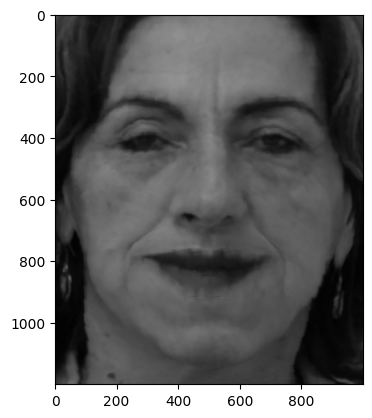

In [40]:
plt.imshow(warpedImg.astype(np.uint8), cmap="grey")
plt.imsave("../meanFace/output/21aWarped.png", warpedImg.astype(np.uint8), cmap="grey")

In [300]:
with open('../../Morphing/meanFace/corr.json') as jsonFile:
    keyPoints = json.load(jsonFile)

In [351]:
im2 = cv2.cvtColor(plt.imread(f"../meanFace/meCroppedUpscaled.jpg"), cv2.COLOR_RGB2GRAY).astype(np.float64)
im2Points = keyPoints['im1Points']

avgImg = plt.imread(f"../meanFace/output/averageFaceUpscaled.png").astype(np.float64)
avgPoints = np.array([read_pts(f"../meanFace/points/{i}a.pts")*4 for i in range(1, 201)])
avgPoints = np.floor(np.average(avgPoints, axis=(0)))
im2Points = np.array(im2Points) * 4
print(im2Points.shape)
print(avgPoints.shape)
avgPoints = list(avgPoints)
im2Points = list(im2Points)
avgPoints.extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
avgPoints.extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])
im2Points.extend([[0,im2.shape[0]], [im2.shape[1],im2.shape[0]], [0,0], [im2.shape[1],0]])
im2Points.extend([[0,im2.shape[0]//2], [im2.shape[1],im2.shape[0]//2], [im2.shape[1]//2,im2.shape[0]], [im2.shape[1]//2,0]])

avgPoints = np.array(avgPoints)
im2Points = np.array(im2Points)
triAverage = Delaunay(avgPoints)
print(im2Points.shape)
print(avgPoints.shape)
print(type(im2[0,0]))
print(type(avgPoints[0,0]))
print(im2.shape)
print(np.max(im2))
print(np.min(im2))

(46, 2)
(46, 2)
(54, 2)
(54, 2)
<class 'numpy.float64'>
<class 'numpy.float64'>
(1200, 1000)
255.0
3.0


<Figure size 640x480 with 0 Axes>

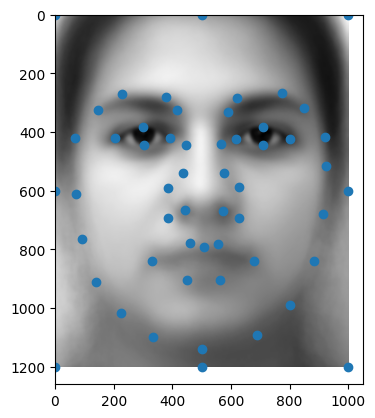

In [308]:
fig = plt.figure()
fig, ax = plt.subplots()
ax.imshow(avgImg)

plt.plot(avgPoints[:,0], avgPoints[:,1], 'o')
ax.set_aspect('equal', adjustable='box')

In [309]:
warpedImg = warpImg(im2Points, triAverage, avgPoints, avgImg)

In [310]:
np.max(warpedImg)

np.float64(7.999999999999545)

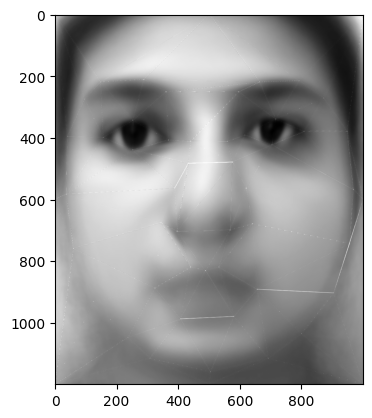

In [311]:
plt.imshow(np.clip(warpedImg, 0, 1), cmap="grey")
# plt.imsave("../meanFace/output/meanWarpedToMe.png", np.clip(warpedImg, 0, 1), cmap="grey")

In [373]:
im2 = plt.imread(f"../meanFace/meCroppedUpscaled.jpg").astype(np.float64)
extrapolatedPoints = im2Points + 0.5*(im2Points-avgPoints)
triIm = Delaunay(im2Points)
extrapolatedImg = warpImg(extrapolatedPoints, triIm, im2Points, im2)

In [374]:
extrapolatedImg = np.clip(extrapolatedImg.astype(np.uint8), 0, 255)
# extrapolatedImg = extrapolatedImg.astype(np.uint8)

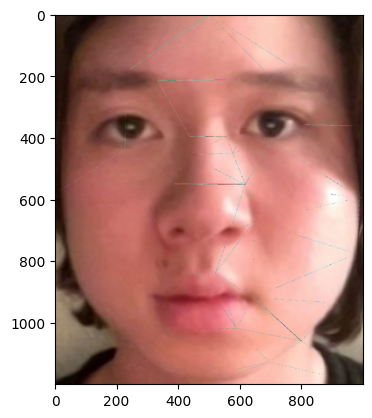

In [375]:
plt.imshow(extrapolatedImg)
plt.imsave("../meanFace/output/extrapolate1.jpg", extrapolatedImg.astype(np.uint8))

In [378]:
from sklearn.decomposition import PCA

In [385]:
avgImg = cv2.cvtColor(plt.imread(f"../meanFace/output/smileAverageFace.png"), cv2.COLOR_RGB2GRAY)
avgImg.shape

(300, 250)

In [386]:
pca = PCA(10)
pca.fit(avgImg)


PCA(n_components=10)